NLP это широкое направление в области ИИ, которая включает в себя множество задач, одной из них является машинный перевод. Моя работа посвящена обработки текста для дальнейшего применения его в задаче перевода.

**Целью** работы является подготовка и обработка данных для модели глубокого обучения, создание модели.

Задачи:

1. Сбор данных

2. Подготовка данных к обработке

3. Обработка данных

4. Создание модели

5. Обработка данных другим способ

6. Создание другой модели

7. Сравнение и тестирование моделей

8. Вывод

In [1]:
import pandas as pd
import string
import re
import time
import tensorflow as tf
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.translate.bleu_score as bleu

# Сбор данных

датасет: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate/data

Загрузим данные

In [2]:
data = pd.read_csv("/content/drive/MyDrive/rus.txt", delimiter='\t', header=None, nrows=15000)
data.head()


,0,1,2
0,Go.,Марш!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Иди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Идите.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Здравствуйте.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Привет!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


Датасет представляет из себя предложения на англйимком и их перевод на русском, в датасете нет повторяющихся значений

# Подготовка данных

Уберем лишний столбец

In [3]:
data = data.drop(2, axis=1)
data.rename(columns={0: 'eng', 1: 'rus'}, inplace=True)

In [4]:
data

,eng,rus
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
14995,I wasn't hired.,Меня не взяли на работу.
14996,I wasn't hired.,Меня не наняли.
14997,I wasn't lucky.,Мне не повезло.
14998,I wasn't lucky.,Мне не везло.


In [5]:
english = list(data['eng'])
russian = list(data['rus'])
len(english), len(russian)

(15000, 15000)

Проверим, что в датасете отсутсвуют пустые строки

In [6]:
pd.isnull(data).sum()

eng    0
rus    0
dtype: int64

Уберем знаки препинания из предложений

In [7]:
todel = string.punctuation + '«' + '»' + string.digits
p = re.compile("[" + re.escape(todel) + "]")

In [8]:
data['eng'] = data['eng'].replace(to_replace = p, value= '')
data['rus'] = data['rus'].replace(to_replace = p, value= '')

In [9]:
data[data['rus'].str.contains('«')]

,eng,rus


In [10]:
english2 = list(data['eng'])
russian2 = list(data['rus'])

# Обработка данных

## Токенизация английских предложений

Для работы с текстовыми данными в NLP часто приходится токенизировать предложения, тексты. Токенизировать подразумевает разбиение предложений на токены (слова). С помощью библиотеки Keras создадим класс Tokenizer, чтобы преобразовать текст в последовательность целых чисел (векторизация текста)

fit_on_texts - построение внутреннего словаря токенизатора

texts_to_sequences - позволяет преобразовать каждое предложение из списка english в последовательность чисел. Каждое число в последовательности представляет собой индекс слова в словаре токенизатора.

In [11]:
engtokenizer = Tokenizer()
engtokenizer.fit_on_texts(list(data['eng']))
vector_eng = engtokenizer.texts_to_sequences(english2)
vector_eng[:5]


[[10], [10], [10], [426], [426]]

10 наиболее встречающихся слов в англйиском

In [12]:
top10word = list(engtokenizer.word_index.items())[:11]
print (top10word)

[('i', 1), ('tom', 2), ('it', 3), ('you', 4), ('im', 5), ('a', 6), ('is', 7), ('me', 8), ('was', 9), ('go', 10), ('we', 11)]


In [13]:
len(data['eng'][data['eng'].str.contains('Tom ')])

1294

График частотности слов в английском без "Том" (так как это имя собственное)

In [14]:
frequency = [0 for i in range(10)]
words = list(engtokenizer.word_index)[:11]
words.pop(1)
for j in words:
  for i in vector_eng:
    frequency[words.index(j)]+=i.count(engtokenizer.word_index[j])

frequency

[3360, 1544, 1417, 1361, 819, 802, 643, 642, 494, 453]

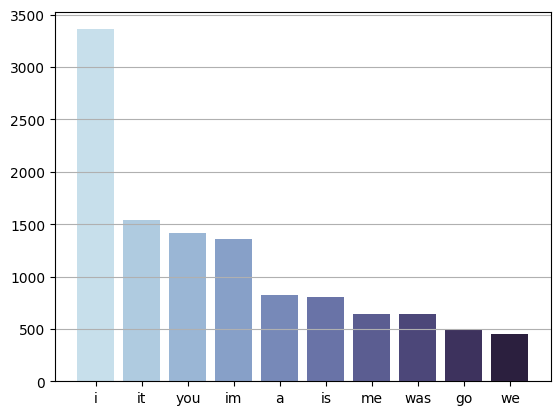

In [15]:
ax = plt.axes()
plt.bar(words, frequency, color=sns.color_palette("ch:s=.25,rot=-.25", len(words)))
ax.yaxis.grid()
plt.show()

## Токенизация русских предложений

Сделаем индикаторы начала и конца предложений.Эти индикаторы помогут модели понять границы предложений

sos - указывает модели на то, что начинается новое предложение

eos - указывает модели на то, что предложение закончилось

In [16]:
a = '<sos> ' + data['rus'] + ' <eos>'
data['rus'] = a

In [17]:
data[:5]

,eng,rus
0,Go,<sos> Марш <eos>
1,Go,<sos> Иди <eos>
2,Go,<sos> Идите <eos>
3,Hi,<sos> Здравствуйте <eos>
4,Hi,<sos> Привет <eos>


Параметр filters используется для указаная символов, которые необходимо удалить из текста. В данном случае удалять ничего не надо, поэтому ставим пустую строку

In [18]:
rustokenizer = Tokenizer(filters='')
rustokenizer.fit_on_texts(list(data['rus']))
vector_rus = rustokenizer.texts_to_sequences(list(data['rus']))
vector_rus[:5]


[[1, 1428, 2], [1, 54, 2], [1, 83, 2], [1, 1116, 2], [1, 254, 2]]

Топ 10 встречающихся слов в русском

In [19]:
top10word = list(rustokenizer.word_index.items())[:11]
print (top10word)

[('<sos>', 1), ('<eos>', 2), ('я', 3), ('том', 4), ('это', 5), ('не', 6), ('ты', 7), ('мне', 8), ('мы', 9), ('он', 10), ('меня', 11)]


График частотности слов в русском без "Том" (так как это имя собственное) и индикаторов начала и конца предложений

In [20]:
frequency = [0 for i in range(10)]
words = list(rustokenizer.word_index)[:13]
words.pop(0)

'<sos>'

In [21]:
words

['<eos>', 'я', 'том', 'это', 'не', 'ты', 'мне', 'мы', 'он', 'меня', 'вы', 'у']

In [22]:
words.pop(0)

'<eos>'

In [23]:
words.pop(1)

'том'

In [24]:

for j in words:
  for i in vector_eng:
    frequency[words.index(j)]+=i.count(rustokenizer.word_index[j])

frequency
words

['я', 'это', 'не', 'ты', 'мне', 'мы', 'он', 'меня', 'вы', 'у']

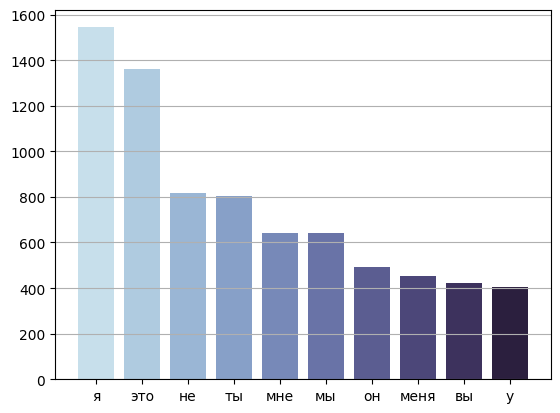

In [25]:
ax = plt.axes()
plt.bar(words, frequency, color=sns.color_palette("ch:s=.25,rot=-.25", len(words)))
ax.yaxis.grid()
plt.show()

## Padding

Padding используется для приведения данных к единому размеру.

pad_sequences заполняет нулями вектор, пока длина вектора не будет равна длиней самого длинного предложения

In [26]:
encoder_pad = pad_sequences(vector_eng)
encoder_pad.shape

(15000, 5)

In [27]:
encoder_pad[0]

array([ 0,  0,  0,  0, 10], dtype=int32)

In [28]:
vector_eng[0]

[10]

Как мы видим, самое длииное предложение состоит из 5 слов, и так как первая строка данных состоит из одного слова (с токеном 10), все остальные значения нули

С русскими предложениями точно так же:

In [29]:
decoder_pad_input = pad_sequences([values[:-1] for values in vector_rus])
decoder_pad_output = pad_sequences([values[1:] for values in vector_rus])
decoder_pad_input.shape, decoder_pad_output.shape

((15000, 11), (15000, 11))

In [30]:
decoder_pad_input[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1, 1428],
      dtype=int32)

In [31]:
vector_rus[0]

[1, 1428, 2]

# Создание модели

Создадим модель перевода с использованием архитектуры, состоящей из encoder и decoder. Реализуем sequence-to-sequence (seq2seq) модель, основанная на рекуррентных нейронных сетях (RNN).

In [32]:
embedding_dim=256  #размерность векторов эмбеддинга
LSTM_NODES = 256#размерность скрытого состояния
num_encoder_tokens = len(engtokenizer.word_index) #размер словаря входных токенов
num_decoder_tokens = len(rustokenizer.word_index) #размер словаря выходных токенов
maxlen = max(len(i) for i in vector_rus) -1
maxleneng = max(len(i) for i in vector_eng)

В самой модели создается слой Embadding, в котором слова преобразуются в векторы.

Архитектура LSTM подразумевает, что мы подаем ей входной вектор (encoder_embeddings в нашем случае), а он возвращает cell state (записываем его в переменную c) и hidden state (записываем его в переменную h)

encoder_outputs в дальнейшем не используются, а вот cell state и hidden state вместе являются носителями информации.

hidden state - это внутреннее состояние реккурентной сети, которая позволяет сети сохранить информацию о предыдущих данных.
cell state позволяет сети сохранять информацию на протяжении длитеьных временных интервалов.

Внутри LSTM эти состояния отвечают за забывание контента и запоминание нового, вывод информации.


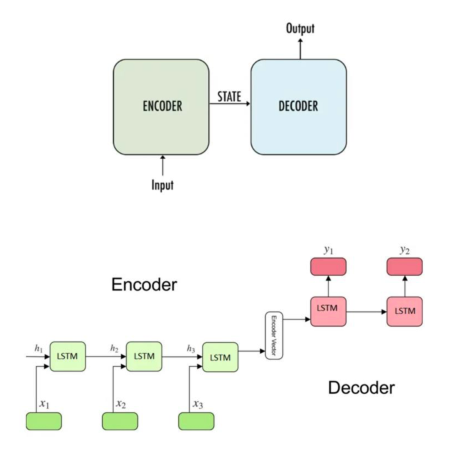

In [33]:
encoder_inputs = Input(shape=(None, ))
encoder_embedding_layer = Embedding(
    input_dim=num_encoder_tokens, output_dim=embedding_dim,
    input_length = maxleneng
)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(LSTM_NODES, return_state = True)

encoder_outputs, h, c = encoder(encoder_embeddings)
encoder_states = [h, c]

Примерно то же самое происходит с decoder

decoder_output генерирует выходную последовательность и далее в Dense layer преобразуется в вероятности с помощью функции softmax

In [34]:
decoder_inputs = Input(shape=(None,))

decoder_embedding_layer = Embedding(
    input_dim=num_decoder_tokens,output_dim=embedding_dim,
    mask_zero=True
)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)

In [35]:
decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Для вывода модели создадим массив, используя one-hot encoding, где 1 будет в позиции соответствующей индексу слова

In [36]:
decoder_target = np.zeros((len(english), maxlen, len(rustokenizer.word_index)+1), dtype='float32')
print(decoder_target.shape)

for i, d in enumerate(decoder_pad_output):
    for t, word in enumerate(d):
        decoder_target[i, t, word] = 1
print(decoder_target.shape)

(15000, 11, 6231)
(15000, 11, 6231)


Метод compile() настраивает модель для обучения, рассмотрим параметры:

optimizer = 'rmsprop' - оптимизатор, который используется для минимизации функции потерь

loss = 'categorical_crossentropy' - функция потерь

metrics = ['accuracy'] - метрика, вычисляемая при обучении

In [37]:
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

Обучим модель на 15.000, где 12.000 для обучающей выборки и 3.000 на тестовую

In [38]:
start = time.time()
model_fit = model1.fit([encoder_pad[:15000], decoder_pad_input[:15000]], decoder_target[:15000], batch_size = 128,
                      epochs = 26,validation_split=0.2,)
end = time.time()


Epoch 1/26
94/94 [==============================] - 25s 171ms/step - loss: 5.7352 - accuracy: 0.3343 - val_loss: 5.1973 - val_accuracy: 0.3081
Epoch 2/26
94/94 [==============================] - 10s 103ms/step - loss: 4.8128 - accuracy: 0.3630 - val_loss: 5.1785 - val_accuracy: 0.3081
Epoch 3/26
94/94 [==============================] - 10s 106ms/step - loss: 4.7333 - accuracy: 0.3647 - val_loss: 5.1275 - val_accuracy: 0.3116
Epoch 4/26
94/94 [==============================] - 8s 83ms/step - loss: 4.6556 - accuracy: 0.3686 - val_loss: 5.0526 - val_accuracy: 0.3171
Epoch 5/26
94/94 [==============================] - 10s 102ms/step - loss: 4.4916 - accuracy: 0.3833 - val_loss: 4.8694 - val_accuracy: 0.3267
Epoch 6/26
94/94 [==============================] - 8s 90ms/step - loss: 4.3464 - accuracy: 0.3951 - val_loss: 4.7995 - val_accuracy: 0.3369
Epoch 7/26
94/94 [==============================] - 8s 88ms/step - loss: 4.2312 - accuracy: 0.4001 - val_loss: 4.7399 - val_accuracy: 0.3531
Epoch

Можно увидеть accuracy, loss тестовой и обучающей выборки на каждой эпохе

In [39]:
print(f'Время обучения: {end-start}')

Время обучения: 259.15133595466614


На графическом процессоре модель быстро обучалась, это заняло всего 259 секунд (на обычном процессоре гораздо дольше)

In [40]:
model1.save('translator_model')

Создадим модель кодировщика, которая будет принимать дополненные токены слов, а внутри уже будет преобразовывать их в векторы

In [41]:
encoder_model = Model(encoder_inputs, encoder_states)

Создадим модель декодера, которая будет принимать два состояния (cell_state и hidden state), токен слова, а возвращать будет вероятности. На картинке можно увидеть, что декодер как раз принимает "одно слово" (токен) и состояния на каждом шаге, далее в функции перевода как раз и создается цикл для обновления состояний и слова

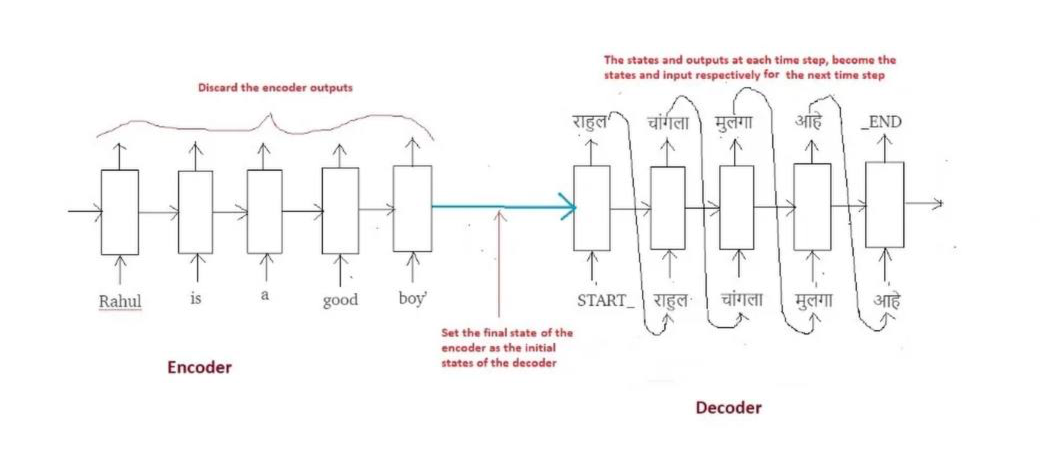

In [42]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_token = Input(shape=(1,))
decoder_inputs_token_x = decoder_embedding_layer(decoder_inputs_token)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_token_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [43]:
decoder_model1 = Model([decoder_inputs_token] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [44]:
rus_dict = rustokenizer.word_index
eng_dict = engtokenizer.word_index

In [45]:
reverse_dict = {v:k for k, v in rus_dict.items()}

In [149]:
def translate(input_seq):
    translation = ''
    states_value = encoder_model(input_seq)
    target = np.zeros((1,1))
    target[0,0] = rus_dict['<sos>']
    stop_condition = False
    while not stop_condition:
        output_token, hidden_state, cell_state = decoder_model1([target]+states_value)
        char_index = np.argmax(output_token[0,-1,:])
        char =  reverse_dict[char_index]
        if char=='<eos>' or len(translation)>=maxlen:
            stop_condition=True
            continue
        translation += ' '+char
        states_value = [hidden_state,cell_state]
        target[0,0] = rus_dict[char]
    return translation

In [240]:
text = np.random.choice(len(english))
text

6911

In [241]:
input = encoder_pad[text:text+1]
translation = translate(input)
print(english[text] ,' - ', translation)
print('Правильный перевод: ', russian[text])

It was Tom's.  -   это был том
Правильный перевод:  Это принадлежало Тому.


# Обработка данных самостоятельно

### Токенизация

Для начала создадим список уникальных слов на английском и на русском

In [242]:
unique_english = []
for sen in data['eng']:
    for word in sen.split():
        if word not in unique_english:
            unique_english.append(word)


unique_english[:5], len(unique_english)

(['Go', 'Hi', 'Run', 'Who', 'Wow'], 2560)

In [243]:
unique_russian = ['<eos>', '<sos>']
for sen in data['rus']:
    for word in sen.split():
        if word not in unique_russian:
            unique_russian.append(word)


unique_russian[:5], len(unique_russian)

(['<eos>', '<sos>', 'Марш', 'Иди', 'Идите'], 6768)

In [244]:
for i in range(2,len(unique_russian)):
  if '<eos>' in unique_russian[i]:
    unique_russian[i] = unique_russian[i].replace('<eos>', '')
  if '<sos>' in unique_russian[i]:
    unique_russian[i] = unique_russian[i].replace('<sos>', '')
unique_russian[:5]

['<eos>', '<sos>', 'Марш', 'Иди', 'Идите']

In [245]:
unique_russian = list(map(str.lower, unique_russian))
unique_english = list(map(str.lower, unique_english))
unique_english[:5]

['go', 'hi', 'run', 'who', 'wow']

Теперь нужно составить словарь, где индекс будет являться слово, а значение это уровень частотности слова (самое используемое слово будет со значением 1 и т.д.)

In [246]:
frequency_dict_eng = {word: 0 for word in unique_english}
for sen in list(data['eng'].str.split()):
  for word in sen:
    frequency_dict_eng[word.lower()]+=1

frequency_dict_eng = dict(sorted(frequency_dict_eng.items(), key=lambda item: item[1], reverse=True)) #словарь с количеством попадания слов в столбце

In [247]:
frequency_dict_eng = dict([(word, i+1) for i,word in enumerate(frequency_dict_eng)])

In [248]:
frequency_dict_rus = {word: 0 for word in unique_russian}
for sen in russian2:
  for word in sen.split():
    if '<eos>' in word:
      word= word.replace('<eos>', '')
    if '<sos>' in word:
      word = word.replace('<sos>', '')
    frequency_dict_rus[word.lower()]+=1

frequency_dict_rus = dict(sorted(frequency_dict_rus.items(), key=lambda item: item[1], reverse=True))

In [249]:
frequency_dict_rus = dict([(word, i+1) for i,word in enumerate(frequency_dict_rus)])
for key in frequency_dict_rus:
  frequency_dict_rus[key]+=2
frequency_dict_rus['<eos>'] = 1
frequency_dict_rus['<sos>'] = 2

Проверим, есть ли повторяющийся значения:

In [250]:
len(frequency_dict_rus.values()), len(set(frequency_dict_rus.values()))

(6228, 6228)

Создадим список из токенов для каждого предложения

In [251]:
sentence_eng = []
for sen in english2:
  sentence = []
  for word in sen.split():
    sentence.append(frequency_dict_eng[word.lower()])
  sentence_eng.append(sentence)

Проверим совпадают ли предложения с токенами

In [252]:
sentence_eng[1], frequency_dict_eng['go']

([10], 10)

In [253]:
english2[-1]

'I wasnt lying'

In [254]:
sentence_eng[-1], frequency_dict_eng['who'], frequency_dict_eng['needs'], frequency_dict_eng['them']

([1, 160, 164], 41, 188, 108)

In [255]:
sentence_rus_input = []
sentence_rus_output = []
for sen in russian2:
  sentence_in = [1]
  sentence_out = []
  for word in sen.split():
    sentence_in.append(frequency_dict_rus[word.lower()])
    sentence_out.append(frequency_dict_rus[word.lower()])
  sentence_rus_input.append(sentence_in)
  sentence_out.append(2)
  sentence_rus_output.append(sentence_out)

In [256]:
sentence_rus_input[1], sentence_rus_output[1], frequency_dict_rus['иди']

([1, 54], [54, 2], 54)

## Padding

Создадим массивы

In [257]:
maxleneng2 = max([len(i.split()) for i in english2])
maxlenrus2 = max([len(i) for i in sentence_rus_input])
maxlenrus2, maxlen, maxleneng2, maxleneng

(11, 11, 5, 5)

In [258]:
def padding(dt, maxlen, zeros_end=False):
  result =  np.array([0 for i in range(maxlen)])
  for i in range(len(dt)):
    if maxlen - len(dt[i])!=0:
      dif = maxlen - len(dt[i])
      if not zeros_end:
        m = [0 for j in range(dif)] + dt[i]
      else:
        m = dt[i] + [0 for j in range(dif)]
    else:
      m = dt[i]

    result = np.vstack((result, m))
  result = np.delete(result,0,axis=0)

  return result

In [259]:
encoder_pad[-1]

array([  0,   0,   1, 160, 164], dtype=int32)

In [260]:
encoder_pad2 = padding(sentence_eng, maxleneng2)

In [261]:
encoder_pad2[-1]

array([  0,   0,   1, 160, 164])

Готовый padding из библиотеки совпадает с результатом нашей функции

In [262]:
decoder_pad2_forinput = padding(sentence_rus_input, maxlenrus2)
decoder_pad2_foroutput = padding(sentence_rus_output, maxlenrus2)

In [263]:
decoder_pad2_forinput[0], decoder_pad2_foroutput[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1, 1429]),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 1429,    2]))

In [265]:
decoder_pad_input[0], decoder_pad_output[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    1, 1428],
       dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 1428,    2],
       dtype=int32))

## Embadding

Воспользуемся библиотекой GloVe, она создает векторы слов, анализируя, как часто пары слов встречаются вместе в большом текстовом корпусе.

Благодаря embadding можно измерить сходство между словами.

Загрузим предобученные векторные представления слов:

In [266]:
embeddings_dictionary = dict()
embedding_dim = 100

with open('/content/drive/MyDrive/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [267]:
embedding_matrix = np.zeros((len(unique_english), embedding_dim))

for word, index in frequency_dict_eng.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix[:3]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [269]:
unique_english[0], frequency_dict_eng['go']

('go', 10)

In [270]:
embeddings_dictionary['go']

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ,  0.51755 ,  0.51998 ,
        0.15218 ,  0.41485 , -0.12377 , -0.37222 ,  0.0273  ,  0.75673 ,
       -0.8739  ,  0.58935 ,  0.46662 ,  0.62918 ,  0.092603, -0.012868,
       -0.015169,  0.25567 , -0.43025 , -0.77668 ,  0.71449 , -0.3834  ,
       -0.69638 ,  0.23522 ,  0.11396 ,  0.02778 ,  0.071357,  0.87409 ,
       -0.1281  ,  0.063576,  0.067867, -0.50181 , -0.28523 , -0.072536,
       -0.50738 , -0.6914  , -0.53579 , -0.11361 , -0.38234 , -0.12414 ,
        0.011214, -1.1622  ,  0.037057, -0.18495 ,  0.01416 ,  0.87193 ,
       -0.097309, -2.3565  , -0.14554 ,  0.28275 ,  2.0053  ,  0.23439 ,
       -0.38298 ,  0.69539 , -0.44916 , -0.094157,  0.90527 ,  0.65764 ,
        0.27628 ,  0.30688 , -0.57781 , -0.22987 , -0.083043, -0.57236 ,
       -0.299   , -0.81112 ,  0.039752, -0.05681 , -0.48879 , -0.18091 ,
       -0.28152 , -0.20559 ,  0.4932  , -0.033999, 

Сравним совпдают векторные предстваления слова go

In [271]:
embedding_matrix[10] == embeddings_dictionary['go']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Векторное представление из embeddings_dictionary совпадает с векторным представлением соответсвующего индекса из embeddings_matrix

In [272]:
embedding_layer = Embedding(len(unique_english), embedding_dim, weights=[embedding_matrix], input_length = maxleneng)

# Модель на другой обработке данных

Сама модель будет такой же, как предыдущая, только на других данных

In [273]:
LSTM_NODES = 256#размерность скрытого состояния
num_encoder_tokens = len(frequency_dict_eng) #размер словаря входных токенов
num_decoder_tokens = len(frequency_dict_rus) #размер словаря выходных токенов

In [274]:
encoder_inputs = Input(shape=(maxleneng2, ))
encoder_embeddings = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state = True)
encoder_outputs, h, c = encoder(encoder_embeddings)
encoder_states = [h, c]

decoder на входе должен обязательно получать закодированное предложение на русском с индикатором $<sos>$ (без $<eos>$!).

In [275]:
decoder_inputs = Input(shape=(maxlen,))

decoder_embedding_layer = Embedding(
    input_dim=num_decoder_tokens,output_dim=embedding_dim,
    mask_zero=True
)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)

In [276]:
decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [277]:
decoder_target = np.zeros((len(english), maxlenrus2, len(frequency_dict_rus)+1), dtype='float32')
print(decoder_target.shape)

for i, d in enumerate(decoder_pad2_foroutput):
    for t, word in enumerate(d):
        decoder_target[i, t, word] = 1
print(decoder_target.shape)

(15000, 11, 6229)
(15000, 11, 6229)


In [278]:
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [279]:
start2 = time.time()
history = model2.fit([encoder_pad2[:15000], decoder_pad2_forinput[:15000]], decoder_target[:15000], batch_size = 128,
                      epochs = 25,validation_split=0.2,)
end2 = time.time()

Epoch 1/25
94/94 [==============================] - 26s 195ms/step - loss: 5.4174 - accuracy: 0.3403 - val_loss: 5.1562 - val_accuracy: 0.3105
Epoch 2/25
94/94 [==============================] - 10s 111ms/step - loss: 4.7232 - accuracy: 0.3696 - val_loss: 5.0244 - val_accuracy: 0.3333
Epoch 3/25
94/94 [==============================] - 8s 90ms/step - loss: 4.4984 - accuracy: 0.4017 - val_loss: 4.8026 - val_accuracy: 0.3535
Epoch 4/25
94/94 [==============================] - 10s 109ms/step - loss: 4.3031 - accuracy: 0.4195 - val_loss: 4.6970 - val_accuracy: 0.3767
Epoch 5/25
94/94 [==============================] - 9s 99ms/step - loss: 4.1132 - accuracy: 0.4363 - val_loss: 4.5899 - val_accuracy: 0.3991
Epoch 6/25
94/94 [==============================] - 11s 119ms/step - loss: 3.9334 - accuracy: 0.4527 - val_loss: 4.4160 - val_accuracy: 0.4167
Epoch 7/25
94/94 [==============================] - 8s 87ms/step - loss: 3.7713 - accuracy: 0.4654 - val_loss: 4.3082 - val_accuracy: 0.4245
Epoch

In [280]:
print(f'Время обучение второй модели: {end2-start2}')

Время обучение второй модели: 275.5542838573456


Вторая модель обучалась примерно столько же, сколько и предыдущая, всего это заняло 275 секунд

In [281]:
model2.save('translator_model2')

In [282]:
encoder_model2 = Model(encoder_inputs, encoder_states)

In [283]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_token = Input(shape=(1,))
decoder_inputs_token_x = decoder_embedding_layer(decoder_inputs_token)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_token_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [284]:
decoder_model2 = Model([decoder_inputs_token] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [285]:
reverse_dict2 = {num:word for word,num in frequency_dict_rus.items()}

In [286]:
def translate2(input_seq):
    translation = ''
    states_value = encoder_model2(input_seq)
    target = np.zeros((1,1))
    target[0,0] = frequency_dict_rus['<sos>']
    stop_condition = False
    while not stop_condition:
        output_token,hidden_state,cell_state = decoder_model2([target]+states_value)
        char_index = np.argmax(output_token[0,-1,:])
        char = reverse_dict2[char_index]
        if char == '<eos>' or len(translation)>=maxlenrus2:
            stop_condition = True
            continue
        translation+=' '+char
        states_value = [hidden_state,cell_state]
        target[0,0] = frequency_dict_rus[char]
    return translation

In [300]:
text = np.random.choice(len(english[:15000]))
input = encoder_pad[text:text+1]
translation = translate2(input)
print(english[text] ,' - ', translation)
print('Правильный перевод: ', russian[text])

Dress warmly.  -   одевайтесь
Правильный перевод:  Одевайся тепло.


In [317]:
text = np.random.choice(len(english[:15000]))
input = encoder_pad[text:text+1]
translation = translate2(input)
print(english[text] ,' - ', translation)
print('Правильный перевод: ', russian[text])

Let's go away.  -   давай пойдём
Правильный перевод:  Давай уйдём.


In [338]:
text = np.random.choice(len(english[:15000]))
input = encoder_pad[text:text+1]
translation = translate2(input)
print(english[text] ,' - ', translation)
print('Правильный перевод: ', russian[text])

I'm crazy.  -   я сумасшедший
Правильный перевод:  Я сумасшедшая.


In [343]:
text = np.random.choice(len(english[:15000]))
input = encoder_pad[text:text+1]
translation = translate2(input)
print(english[text] ,' - ', translation)
print('Правильный перевод: ', russian[text])

Let's go out.  -   давай пойдём
Правильный перевод:  Давайте куда-нибудь сходим.


# Сравнение моделей, графики, тестирование

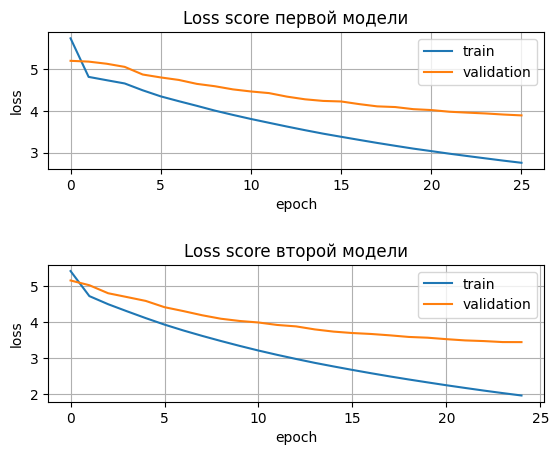

In [344]:
plt.subplot(2,1,1)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Loss score первой модели')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'validation'])

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss score второй модели')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'validation'])

plt.subplots_adjust(hspace=0.7)
plt.show()

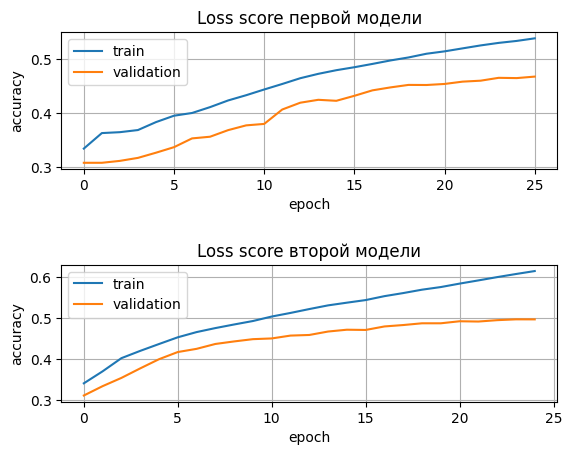

In [345]:
plt.subplot(2,1,1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Loss score первой модели')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'validation'])

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Loss score второй модели')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'validation'])

plt.subplots_adjust(hspace=0.7)
plt.show()

Исходя из графиков, можно сказать, что модель, которая обучалась на самостоятельно обработанных данных показывает лучшую точность. Возможно, это из-за эмбеддинга, который осуществлялся отдельно через GloVe, так как эта модель обучалась на больших корпусах текста и лучше отражает близость слов.

Accuracy первой модели = 0.53

Accuracy второй модели = 0.61
В принципе, обе модели имеют низкий accuracy, от того перевод не всегда совпадает/имеет смысл. Посмотрим так же на BLEU-score, который измеряет различия между эталонным переводом и переводом нашей модели:

In [363]:
text = np.random.choice(len(english[:15000]))
s = russian[text].lower()
actual = [s.split()]
input = encoder_pad[text:text+1]
model_trans = translate2(input).split()

print("BLEU Score ВТОРОЙ модели: ",bleu.sentence_bleu(actual, model_trans, weights = (0.5, 0.5)))

BLEU Score ВТОРОЙ модели:  0.5773502691896257


In [364]:
actual, model_trans

([['я', 'люблю', 'готовить.']], ['я', 'люблю', 'чай'])

In [365]:

model_trans = translate(input).split()

print("BLEU Score ПЕРВОЙ модели: ",bleu.sentence_bleu(actual, model_trans, weights = (0.5, 0.5)))

BLEU Score ПЕРВОЙ модели:  0.5773502691896257


In [559]:
text = np.random.choice(len(english[:15000]))
s = russian[text].lower()
actual = [s.split()]
input = encoder_pad[text:text+1]
model_trans = translate2(input).split()

print("BLEU Score ВТОРОЙ модели: ",bleu.sentence_bleu(actual, model_trans, weights = (0.5, 0.5)))

BLEU Score ВТОРОЙ модели:  0.7165313105737893


In [560]:
model_trans = translate(input).split()

print("BLEU Score ПЕРВОЙ модели: ",bleu.sentence_bleu(actual, model_trans, weights = (0.5, 0.5)))

BLEU Score ПЕРВОЙ модели:  0


In [561]:
actual, model_trans

([['у', 'нас', 'есть', 'еда.']], ['мы', 'можем', 'в'])

Как мы видим, ни одна модель не показала BLEU-score равный 1, значит ни одно предложение не было переведено правильно до конца. Мы так же можем снова убедиться, что вторая модель работает лучше первой

# Вывод

Для NLP крайне необходимо предварительно обрабатывать данные и осуществлять некие преобразования. NLP модели требуют такие операции, как токенизация, дополнение (padding), векторизация и некоторые другие, если того требует модель. В ходе этой работы были проведены все вышеперечисленные методы в двух вариантах. В первом преобразования осуществлялись с помощью библиотек, во втором с помощью самостоятельного ручного преобразования. Так как для построения модели использовалось всего 15.000 предложений и каждая модель обучалась только 25 эпох, то не удивительно, что она не всегда точно предсказывает перевод. Скорее всего модель недообучена. Однако обработать большее количество данных не позволяет объем хранилища компьютера.